In [1]:
import tensorflow as tf
from google.colab import drive

# 使用工具colab的接口挂载google drive目录，这样可以从外部获取数据并且可以把训练好的模型保存在google drive上
drive.mount('/content/gdrive')
tf.test.gpu_device_name()

Mounted at /content/gdrive


'/device:GPU:0'

In [2]:
import scipy.io.wavfile as wav
import numpy as np
from scipy.fftpack import fft
from scipy.fftpack import ifft
from scipy import signal
import scipy
import librosa

def compute_PSD_matrix(audio, window_size):
    """
	First, perform STFT.
	Then, compute the PSD.
	Last, normalize PSD.
    """

    win = np.sqrt(8.0/3.) * librosa.core.stft(audio, center=False)
    stft=librosa.core.stft(audio, center=False)
    magnitude, phase = librosa.magphase(stft)
    z = abs(win / window_size)
    psd_max = np.max(z*z)
    psd = 10 * np.log10(z * z + 0.0000000000000000001)
    PSD = 96 - np.max(psd) + psd
    return win,z,PSD, psd_max, np.max(psd),phase,stft

def Bark(f):
    """returns the bark-scale value for input frequency f (in Hz)"""
    return 13*np.arctan(0.00076*f) + 3.5*np.arctan(pow(f/7500.0, 2))

def quiet(f):
     """returns threshold in quiet measured in SPL at frequency f with an offset 12(in Hz)"""
     thresh = 3.64*pow(f*0.001,-0.8) - 6.5*np.exp(-0.6*pow(0.001*f-3.3,2)) + 0.001*pow(0.001*f,4) - 12
     return thresh

def two_slops(bark_psd, delta_TM, bark_maskee):
    """
	returns the masking threshold for each masker using two slopes as the spread function 
    """
    Ts = []
    for tone_mask in range(bark_psd.shape[0]):
        bark_masker = bark_psd[tone_mask, 0]
        dz = bark_maskee - bark_masker
        zero_index = np.argmax(dz > 0)
        sf = np.zeros(len(dz))
        sf[:zero_index] = 27 * dz[:zero_index]
        sf[zero_index:] = (-27 + 0.37 * max(bark_psd[tone_mask, 1] - 40, 0)) * dz[zero_index:] 
        T = bark_psd[tone_mask, 1] + delta_TM[tone_mask] + sf
        Ts.append(T)
    return Ts
    
def compute_th(PSD, barks, ATH, freqs):
    """ returns the global masking threshold
    """
    # Identification of tonal maskers
    # find the index of maskers that are the local maxima
    length = len(PSD)
    masker_index = signal.argrelextrema(PSD, np.greater)[0]
    
    
    # delete the boundary of maskers for smoothing
    if 0 in masker_index:
        masker_index = np.delete(0)
    if length - 1 in masker_index:
        masker_index = np.delete(length - 1)
    num_local_max = len(masker_index)

    # treat all the maskers as tonal (conservative way)
    # smooth the PSD 
    p_k = pow(10, PSD[masker_index]/10.)    
    p_k_prev = pow(10, PSD[masker_index - 1]/10.)
    p_k_post = pow(10, PSD[masker_index + 1]/10.)
    P_TM = 10 * np.log10(p_k_prev + p_k + p_k_post)
    
    # bark_psd: the first column bark, the second column: P_TM, the third column: the index of points
    _BARK = 0
    _PSD = 1
    _INDEX = 2
    bark_psd = np.zeros([num_local_max, 3])
    bark_psd[:, _BARK] = barks[masker_index]
    bark_psd[:, _PSD] = P_TM
    bark_psd[:, _INDEX] = masker_index
    
    # delete the masker that doesn't have the highest PSD within 0.5 Bark around its frequency 
    for i in range(num_local_max):
        next = i + 1
        if next >= bark_psd.shape[0]:
            break
            
        while bark_psd[next, _BARK] - bark_psd[i, _BARK]  < 0.5:
            # masker must be higher than quiet threshold
            if quiet(freqs[int(bark_psd[i, _INDEX])]) > bark_psd[i, _PSD]:
                bark_psd = np.delete(bark_psd, (i), axis=0)
            if next == bark_psd.shape[0]:
                break
                
            if bark_psd[i, _PSD] < bark_psd[next, _PSD]:
                bark_psd = np.delete(bark_psd, (i), axis=0)
            else:
                bark_psd = np.delete(bark_psd, (next), axis=0)
            if next == bark_psd.shape[0]:
                break        
    
    # compute the individual masking threshold
    delta_TM = 1 * (-6.025  -0.275 * bark_psd[:, 0])
    Ts = two_slops(bark_psd, delta_TM, barks) 
    Ts = np.array(Ts)
    
    # compute the global masking threshold
    theta_x = np.sum(pow(10, Ts/10.), axis=0) + pow(10, ATH/10.) 
 
    return theta_x

def generate_th(audio, fs, window_size=2048):
    """
	returns the masking threshold theta_xs and the max psd of the audio
    """
    win,z,PSD, psd_max, max_,phase,stft= compute_PSD_matrix(audio , window_size)  
    freqs = librosa.core.fft_frequencies(fs, window_size)
    barks = Bark(freqs)

    # compute the quiet threshold 
    ATH = np.zeros(len(barks)) - np.inf
    bark_ind = np.argmax(barks > 1)
    ATH[bark_ind:] = quiet(freqs[bark_ind:])

    # compute the global masking threshold theta_xs 
    theta_xs = []
    # compute the global masking threshold in each window
    for i in range(PSD.shape[1]):
        theta_xs.append(compute_th(PSD[:,i], barks, ATH, freqs))
    theta_xs = np.array(theta_xs)
    return win,z, PSD,theta_xs, psd_max,max_,phase,stft

In [ ]:
class Transform(object):
    '''
    Return: PSD
    '''    
    def __init__(self, window_size):
        self.scale = 8. / 3.
        self.frame_length = int(window_size)
        self.frame_step = int(window_size//4)
        self.window_size = window_size
    
    def __call__(self, x, psd_max_ori):
        win = tf.contrib.signal.stft(x, self.frame_length, self.frame_step)
        z = self.scale *tf.abs(win / self.window_size)
        psd = tf.square(z)
        PSD = tf.pow(10., 9.6) / tf.reshape(psd_max_ori, [-1, 1, 1]) * psd
        return PSD

按照文件夹来整个整

In [3]:
import csv    
csv_file=open('/content/gdrive/MyDrive/deepspeech/outfile_addn_oritrans_WER.csv')    
csv_reader_lines = csv.reader(csv_file)   
data_frame={} 
data_WER={}
data_trans={}   
num = 0
for one_line in csv_reader_lines:
  if(one_line[1]=='ID'):
    continue
  else:
    data_frame[one_line[1]]=int(one_line[3])  
    data_WER[one_line[1]]=float(one_line[5]) 
    data_trans[one_line[1]]=one_line[2].lower()
    num+=1    
print(data_frame)
print(data_WER)
print(data_trans)

{'19-198-0000': 1, '19-198-0001': 3, '19-198-0002': 2, '19-198-0003': 3, '19-198-0004': 3, '19-198-0005': 3, '19-198-0006': 3, '19-198-0007': 3, '19-198-0008': 1, '19-198-0009': 3, '19-198-0010': 3, '19-198-0011': 3, '19-198-0012': 3, '19-198-0013': 3, '19-198-0014': 3, '19-198-0015': 3, '19-198-0016': 3, '19-198-0017': 3, '19-198-0018': 3, '19-198-0019': 3, '19-198-0020': 3, '19-198-0021': 3, '19-198-0022': 3, '19-198-0023': 3, '19-198-0024': 3, '19-198-0025': 3, '19-198-0026': 3, '19-198-0027': 3, '19-198-0028': 3, '19-198-0029': 3, '19-198-0030': 3, '19-198-0031': 3, '19-198-0032': 3, '19-198-0033': 3, '19-198-0034': 3, '19-198-0035': 3, '19-198-0036': 3, '19-198-0037': 1, '19-227-0000': 3, '19-227-0001': 3, '19-227-0002': 3, '19-227-0003': 3, '19-227-0004': 3, '19-227-0005': 3, '19-227-0006': 3, '19-227-0007': 3, '19-227-0008': 3, '19-227-0009': 3, '19-227-0010': 3, '19-227-0011': 3, '19-227-0012': 3, '19-227-0013': 2, '19-227-0014': 3, '19-227-0015': 3, '19-227-0016': 3, '19-227-0

In [4]:
import numpy as np  
import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
index_list = np.load("/content/gdrive/MyDrive/deepspeech/index.npy") 

# restore np.load for future normal usage
np.load = np_load_old
#error_list = np.load("/content/gdrive/MyDrive/deepspeech/error_all.npy") 
#print(error_list)  

indexlist=index_list.tolist()
dic_index={}
i=0
for key in data_frame:

  dic_index[key]=indexlist[i]
  i+=1
  print(key,dic_index[key])

19-198-0000 [45, 49, 50]
19-198-0001 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120]
19-198-0002 [3, 4, 6, 7, 9, 16, 18, 19, 20, 24, 29, 30, 31, 32, 33, 34, 35, 38, 54, 55, 56, 57, 58, 59, 60, 62, 65, 73, 74, 76, 77, 78, 86, 91, 92, 97, 103, 105, 112, 113, 114, 117, 118, 119, 120, 121, 124, 130, 131, 133, 134, 135, 141, 142, 143, 145, 150, 153, 154, 157]
19-198-0003 [0, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 35, 36, 37, 38, 39, 40, 42, 48, 49, 50, 51, 53, 54, 55, 62, 63, 64, 65, 66, 67, 68, 

In [6]:
#youjige没有填上


import os
import copy
import wave
import librosa
import scipy.io.wavfile as wav
import numpy as np
 
def add_noise(audio_path):

  #audio_path='/content/gdrive/MyDrive/deepspeech/audios_wav/19-198-0001.wav'
  print(audio_path)
  scale = 8. / 3.
  window_size=2048
  frame_length = 2048
  frame_step = 512
  fs, data_true = wav.read(audio_path)
  length=len(data_true)
  data_true=data_true.reshape((length,)).astype(np.float64)
  win_ori,z_ori,PSD, theta_xs, psd_max, max_,phase,stft=generate_th(data_true, fs)
  print(length)
  print("PSD",PSD.shape)
  print(win_ori.shape)
  print("THETA_XS",theta_xs.shape)

  theta_xs_=theta_xs.transpose()
  a=theta_xs_*psd_max.reshape([-1, 1, 1])
  b=pow(10., 9.6)
  psd=a/b
  z_=np.sqrt(psd)/scale*2048.0
  print(z_.shape)
  z=z_.reshape((z_.shape[1],z_.shape[2]))
  #print(z)

  istft=z*phase
  y_inv=librosa.core.istft(istft)
  data_pad=copy.deepcopy(data_true)
  #print(data_pad)
  print(y_inv)
  for i in range(len(y_inv)):
    data_pad[i]+=y_inv[i]

  data_pad=data_pad.astype(np.int16)
  return data_pad
  #wavfile.write("/content/gdrive/MyDrive/deepspeech/audios_all_wav/19-198-0001.wav", fs, data_pad)
 
 
path = r"/content/gdrive/MyDrive/deepspeech/audios_wav"
path_noise=r"/content/gdrive/MyDrive/deepspeech/play"
okfiles=os.listdir(path_noise)
filenames = os.listdir(path)
#filenames=['83-11691-00'+i for i in ['32','34','38','39','40','41','42','43','44','45']]
for filename in filenames:
    if(filename in okfiles):
      continue
    name_,category=os.path.splitext(filename)
    if(category!=".wav"):
      continue
    name=path+'/'+filename

    print("add noise File Name is ", name)
    #fs,data = wav.read(name)
    path_noise_final=path_noise +'/'+ filename
    data_noise = add_noise(name)
    fs=16000
    
    wav.write(path_noise_final,fs, data_noise)
    print(path_noise_final)
    print("=========================")
 
print('run over！')

add noise File Name is  /content/gdrive/MyDrive/deepspeech/audios_wav/19-227-0017.wav
/content/gdrive/MyDrive/deepspeech/audios_wav/19-227-0017.wav
234080
PSD (1025, 454)
(1025, 454)
THETA_XS (454, 1025)
(1, 1025, 454)
[ -47.05999281  -53.09358004  -43.18645585 ... -102.93178657  -83.24735472
  -73.13612076]
/content/gdrive/MyDrive/deepspeech/play/19-227-0017.wav
add noise File Name is  /content/gdrive/MyDrive/deepspeech/audios_wav/19-227-0019.wav
/content/gdrive/MyDrive/deepspeech/audios_wav/19-227-0019.wav
236800
PSD (1025, 459)
(1025, 459)
THETA_XS (459, 1025)
(1, 1025, 459)
[ 27.67251109  35.33489228  60.55967283 ... -11.62917298 -13.55096215
 -20.97020686]
/content/gdrive/MyDrive/deepspeech/play/19-227-0019.wav
add noise File Name is  /content/gdrive/MyDrive/deepspeech/audios_wav/19-227-0022.wav
/content/gdrive/MyDrive/deepspeech/audios_wav/19-227-0022.wav
220000
PSD (1025, 426)
(1025, 426)
THETA_XS (426, 1025)
(1, 1025, 426)
[-44.07288893 -22.42630941 -11.49003263 ... -27.4783929

KeyboardInterrupt: ignored

前面的是全部加噪,后面的要进行frames和random的

In [ ]:
from scipy.io import wavfile
import numpy as np
from scipy.fftpack import fft
from scipy.fftpack import ifft
from scipy import signal
import random
import scipy
import copy

url_already_audio='/content/gdrive/MyDrive/deepspeech/audios_usingphase_wav'
import os
allreadyfile=[]
txt_files=os.listdir(url_already_audio)
print(txt_files)
if len(txt_files)==0:
  pass
else:
  for files in txt_files:
    name,category=os.path.splitext(files)
    allreadyfile.append(name)
print(len(allreadyfile))
url_original_audio='/content/gdrive/MyDrive/deepspeech/audios_wav/'

url = '/content/gdrive/MyDrive/deepspeech/audios_usingphase_random/'

for key in dic_index:
  original_url=url_original_audio+key+'.wav'
  all_url=url_already_audio+'/'+key+'.wav'
  fs, data_true = wav.read(original_url)
  print(original_url)
  fs, data_all = wav.read(all_url)
  data_final=copy.deepcopy(data_true)
  data_n=(len(data_true)-1536)//512
  print(data_n)
  index_all=[i for i in range(data_n)]
  print(index_all)
  #index_all=range(0,data_n)
  n=data_frame[key]
  print(n)
  index_=dic_index[key]
  num_frames=n*len(index_)
  for i in index_:
    for j in range(n):
      index_all.remove(i*n+j)
    #del index_all[i*n:i*(n+1)]
  if(len(index_all)>=num_frames):
    index_random=random.sample(index_all,num_frames)
  else:
    index_random=index_all
  #index_random=int_random(0,data_n,num_frames)
  print(index_random)
  #print(data_true[0*n*512:1*n*512])

  for item in index_random:
    
    data_final[item*512:(item+1)*512]=copy.deepcopy(data_all[item*512:(item+1)*512])

  wavfile.write(url+key+'.wav', fs, data_final)
  print("============================================================================")

流式输出内容被截断，只能显示最后 5000 行内容。
[11, 210, 78, 281, 75, 28, 265, 21, 257, 214, 10, 111, 19, 270, 22, 130, 191, 280, 368, 160, 152, 90, 4, 182, 146, 321, 217, 1, 150, 162, 139, 362, 379, 215, 96, 398, 272, 163, 264, 367, 141, 386, 253, 161, 129, 216, 397, 177, 38, 27, 94, 77, 84, 256, 80, 142, 132, 15, 165, 112, 7, 355, 271, 250, 380, 372, 180, 154, 140, 101, 211, 168, 153, 25, 263, 387, 258, 6, 93, 356, 213, 158, 358, 284, 400, 388, 276, 126, 371, 136, 164, 113, 252, 262, 133, 310, 261, 260, 143, 369, 378, 39, 41, 269, 322, 37, 149, 17, 365, 364, 88, 16, 255, 131, 128, 166, 172, 251, 376, 92, 259, 134, 2, 402, 396, 370, 179, 127, 353, 156, 381, 268, 181, 24, 278, 32, 91, 366, 354, 351, 357, 189, 76, 151, 95, 383, 144, 99, 360, 389, 23, 89, 282, 309, 26, 97, 173, 277, 384, 311, 100, 155, 374, 87, 9, 145, 3, 171, 361, 5, 266, 178, 31, 363, 377, 40, 148, 283, 375, 352, 167, 399, 385, 382, 85, 218, 249, 147, 138]
/content/gdrive/MyDrive/deepspeech/audios_wav/26-496-0024.wav
447
[0, 1, 2, 3, 4, 5

In [ ]:
from scipy.io import wavfile
import numpy as np
from scipy.fftpack import fft
from scipy.fftpack import ifft
from scipy import signal
import random
import scipy
import copy

url_already_audio='/content/gdrive/MyDrive/deepspeech/audios_usingphase_wav'
import os
allreadyfile=[]
txt_files=os.listdir(url_already_audio)
print(txt_files)
if len(txt_files)==0:
  pass
else:
  for files in txt_files:
    name,category=os.path.splitext(files)
    allreadyfile.append(name)
print(len(allreadyfile))
url_original_audio='/content/gdrive/MyDrive/deepspeech/audios_wav/'

url = '/content/gdrive/MyDrive/deepspeech/audios_usingphase_frames/'

for key in dic_index:
  original_url=url_original_audio+key+'.wav'
  all_url=url_already_audio+'/'+key+'.wav'
  fs, data_true = wavfile.read(original_url)
  fs, data_all = wavfile.read(all_url)
  data_final=copy.deepcopy(data_true)
  data_n=(len(data_true)-1536)//512
  print(data_n)
  index_all=[i for i in range(data_n)]
  print(index_all)
  #index_all=range(0,data_n)
  n=data_frame[key]
  print(n)
  index_=dic_index[key]
  num_frames=n*len(index_)
  for i in index_:
    for j in range(n):
      index_all.remove(i*n+j)
    #del index_all[i*n:i*(n+1)]
  if(len(index_all)>=num_frames):
    index_random=random.sample(index_all,num_frames)
  else:
    index_random=index_all
  #index_random=int_random(0,data_n,num_frames)
  #print(index_random)
  #print(data_true[0*n*512:1*n*512])
  print(index_)

  for item in index_:
    
    data_final[item*512*n:(item+1)*512*n]=copy.deepcopy(data_all[item*512*n:(item+1)*512*n])

  wavfile.write(url+key+'.wav', fs, data_final)
  print("============================================================================")

In [ ]:
然后就用别的文件里面的deepspeech来判别这些文件，最后出wer的npy文件
这里是需要出一些图片的
感觉非常的啧啧

SyntaxError: ignored

[[2.93728263e+03 1.99212640e+03 4.02008421e+02 ... 1.40431725e+03
  2.77485277e+03 3.82829902e+03]
 [1.05025776e+03 4.48245092e+03 1.35391538e+03 ... 1.65083827e+03
  2.76536158e+03 1.34073984e+03]
 [2.75196329e+04 2.30318577e+04 2.68097127e+04 ... 2.87604100e+04
  2.76830403e+04 2.38190925e+04]
 ...
 [2.67330204e+01 4.03330726e+02 3.21526562e+02 ... 2.89930203e+01
  1.77940530e+02 7.81965493e+01]
 [5.77629350e+02 4.00250749e+02 4.13836131e+02 ... 8.16865146e+02
  6.04038237e+02 4.91714785e+02]
 [8.00956059e+02 7.88341224e+02 8.43614852e+02 ... 1.11310038e+03
  1.17009078e+03 1.00551401e+03]]


(1, 1025, 364)
[[ 7879.46744404  7568.37453157  8095.83197055 ...  8608.95940913
   8638.98141543  7908.80722341]
 [10016.22087518  9620.76580843 10291.25911887 ... 10943.53642041
  10981.69979229 10053.51701387]
 [12732.50419482 12229.8062852  13082.12963092 ... 13911.29699669
  13959.80983387 12779.91461521]
 ...
 [   65.21977316    62.74676128    79.73803944 ...    47.14548024
     81.55191003    83.12560896]
 [   64.15126476    61.72062879    78.4219407  ...    46.38897146
     80.20498758    81.7519596 ]
 [   63.1026932     60.713681      77.13019531 ...    45.6469019
     78.88297041    80.40369435]]
[42.22222898 31.82222436 27.07453019 ... 48.39783135 50.52084755
 55.05456496]


185856


In [ ]:
import copy
data_pad=copy.deepcopy(data_true)
print(data_pad)
print(y_inv)
for i in range(len(y_inv)):
  data_pad[i]=data_pad[i]+y_inv[i]

print(data_pad)

[ -36.  -39.  -42. ... -147. -118. -145.]
[-25.74791095 -34.68577029 -32.5349435  ...  46.42979713  34.64766535
  28.75191348]
[ -61.74791095  -73.68577029  -74.5349435  ... -147.         -118.
 -145.        ]


我试试这个就是完全的threshold

In [ ]:
import copy
data_pad=copy.deepcopy(data_true)
print(data_pad)
print(y_inv)
for i in range(len(y_inv)):
  data_pad[i]=y_inv[i]

print(data_pad)

[ -36.  -39.  -42. ... -147. -118. -145.]
[42.22222898 31.82222436 27.07453019 ... 48.39783135 50.52084755
 55.05456496]
[  42.22222898   31.82222436   27.07453019 ... -147.         -118.
 -145.        ]


In [ ]:
#data_final=np.asarray(data_pad)
data_pad=data_pad.astype(np.int16)

In [ ]:
data_pad=data_pad.astype(np.int16)
wavfile.write("/content/gdrive/MyDrive/deepspeech/audios_all_wav/19-198-0001.wav", fs, data_pad)

[-5, -7, -6, -4, -13, -6, -5, 3, 1, -10, -13, -18, -22, -30, -39, -38, -28, -17, -25, -43, -51, -46, -43, -42, -39, -37, -27, -13, 0, 3, -6, 1, 11, 17, 25, 15, 21, 37, 53, 64, 49, 35, 28, 28, 31, 38, 41, 45, 57, 52, 30, 13, 3, 20, 21, 21, 21, 26, 37, 37, 28, 26, 11, 11, 10, 14, 22, 19, 11, 20, 25, 22, 29, 32, 48, 64, 55, 45, 47, 49, 52, 51, 57, 51, 57, 64, 72, 70, 63, 51, 49, 29, 29, 26, 25, 22, 24, 10, -4, -21, -32, -23, 0, -8, -11, -8, 3, 10, 14, 18, 33, 36, 36, 40, 53, 61, 65, 56, 44, 33, 27, 23, 27, 38, 33, 26, 19, 16, 25, 38, 34, 22, 15, 19, 20, 22, 18, 25, 26, 25, 24, 23, 22, 18, 9, 9, 13, 11, 9, 15, 19, 26, 20, 16, 26, 39, 54, 55, 53, 53, 52, 55, 63, 85, 93, 89, 86, 73, 70, 57, 46, 36, 31, 30, 19, 7, 5, -6, -5, -12, -11, -17, -18, -13, -6, 1, 3, 9, 14, 21, 42, 49, 50, 57, 72, 92, 101, 98, 92, 81, 72, 69, 64, 67, 61, 55, 53, 49, 43, 34, 37, 50, 45, 37, 30, 33, 37, 34, 35, 21, 13, 16, 24, 27, 24, 24, 23, 21, 25, 23, 22, 29, 43, 50, 54, 54, 59, 62, 62, 74, 83, 74, 76, 80, 71, 60, 5

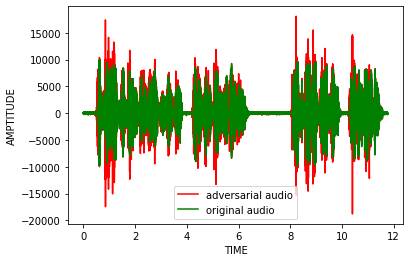

In [ ]:
import matplotlib.pyplot as plt


ori_url="/content/gdrive/MyDrive/deepspeech/audios_wav/19-198-0001.wav"
ad_url="/content/gdrive/MyDrive/deepspeech/audios_all_wav/19-198-0001.wav"

fs, data_ori = wavfile.read(ori_url)
fs, data_ad = wavfile.read(ad_url)
time = np.arange(0, len(data_ori)) * (1.0 / 16000)
#time = np.arange(0, len(samples)) *1


#a=[0,1,1,1,1,1,0,0,0,0,0]
#data=data.tolist()
data_ori_=data_ori.tolist()
data_ad_=data_ad.tolist()

distance=[]
for i in range(len(data_ori)):
  distance.append(data_ori_[i]-data_ad_[i])

print(distance)
#redata=redata.tolist()
#nozeroindex = np.nonzero(distance)[0]
#print(nozeroindex)

plt.plot(time, data_ad_, color='red', label='adversarial audio')
plt.plot(time, data_ori_, color='green', label='original audio')
#plt.plot(time, distance,color='skyblue', label='Distance')
plt.legend() # 显示图例
#plt.title("语音信号时域波形")
plt.xlabel("TIME")
plt.ylabel("AMPTITUDE")
# plt.savefig("your dir\语音信号时域波形图", dpi=600)
plt.show()

下面的没啥用，都是写废了的代码，但是又舍不得删，哈哈哈哈这就是自恋的心理吧

In [ ]:
a=theta_xs/tf.pow(10.,9.6)
#b=tf.reshape(psd_max, [-1, 1, 1])
b=psd_max
print(b)
tf.cast(a,dtype=tf.float64)
#tf.cast(b,dtype=tf.float64)
print(a.dtype)
print(b.dtype)
#reverse
psd=a*b
#psd=theta_xs/tf.pow(10.,9.6) * tf.reshape(psd_max, [-1, 1, 1])
z=tf.sqrt(psd)/scale
win=z*window_size
win = tf.transpose(win, perm=[1, 0])

print(win.shape)
print(win_ori.shape)
win=win.numpy()
print(tf.is_tensor(win))
for i in range(win_ori.shape[0]):
  for j in range(win_ori.shape[1]):
    if(win_ori[i][j]<0):
      win[i][j]=win[i][j]*(-1)

win=tf.convert_to_tensor(win,dtype=tf.float64)

inputs = tf.cast(win, tf.complex64) 

waveform=tf.signal.inverse_stft(inputs, frame_length, frame_step,
    window_fn=tf.signal.inverse_stft_window_fn(frame_step))


data=np.array(data_true)
data=data.reshape((1,length)).astype(np.float64)
print(data.shape)
test=MaskThresholdDistance(data)
redata,loss_=test.train(data)
data_all=redata.reshape((length,)).astype(np.int16)

wavfile.write("/content/gdrive/MyDrive/deepspeech/audios_all_wav/19-198-0001.wav", fs, data_all)

In [ ]:
from scipy.io import wavfile
import numpy as np
from scipy.fftpack import fft
from scipy.fftpack import ifft
from scipy import signal
import scipy
"""
def compute_PSD_matrix(audio, window_size):


    win = np.sqrt(8.0/3.) * librosa.core.stft(audio, center=False)
    z = abs(win / window_size)
    psd_max = np.max(z*z)
    psd = 10 * np.log10(z * z + 0.0000000000000000001)
    PSD = 96 - np.max(psd) + psd
    return win,PSD, psd_max, np.max(psd)
"""

audio_path='/content/gdrive/MyDrive/deepspeech/audios_wav/19-198-0001.wav'
scale = 8. / 3.
window_size=2048
frame_length = 2048
frame_step = 512
fs, data_true = wavfile.read(audio_path)
length=len(data_true)
data_true=data_true.reshape((length,)).astype(np.float64)
win_ori,PSD, theta_xs, psd_max, max_=generate_th(data_true, fs)
print(length)
print("PSD",PSD.shape)
print(win_ori.shape)
print("THETA_XS",theta_xs.shape)

print(96 in theta_xs)

theta_xs=theta_xs.transpose(1,0)
print("THETA_XS_transpose",theta_xs)
print("max_",max_)
psd=theta_xs+max_-96
psd=psd/10
psd=10**psd-0.0000000000000000001
print("psd",psd)
z=np.sqrt(psd)
print(z.shape)
win=z*2048
win=win/np.sqrt(8.0/3.)
#for i in range(win_ori.shape[0]):
#  for j in range(win_ori.shape[1]):
#    if(win_ori[i][j]<0):
#      win[i][j]=win[i][j]*(-1)
print("win",win)
print("original win",win_ori)





#istft=win/np.sqrt(8.0/3.)

audio = librosa.griffinlim(win)

print(data_true)
print(audio)

188240
PSD (1025, 364)
(1025, 364)
THETA_XS (364, 1025)
False
THETA_XS_transpose [[1.39504947e+05 1.28706686e+05 1.47271547e+05 ... 1.66531808e+05
  1.67695325e+05 1.40545795e+05]
 [2.25425822e+05 2.07976930e+05 2.37975859e+05 ... 2.69098484e+05
  2.70978610e+05 2.27107727e+05]
 [3.64270106e+05 3.36074091e+05 3.84549962e+05 ... 4.34841637e+05
  4.37879770e+05 3.66987930e+05]
 ...
 [9.55772311e+00 8.84664307e+00 1.42865374e+01 ... 4.99431585e+00
  1.49439068e+01 1.55262136e+01]
 [9.24711636e+00 8.55966091e+00 1.38188228e+01 ... 4.83532159e+00
  1.44543521e+01 1.50173126e+01]
 [8.94729315e+00 8.28264420e+00 1.33673321e+01 ... 4.68186073e+00
  1.39817776e+01 1.45260617e+01]]
max_ 64.77681683240978
psd [[       inf        inf        inf ...        inf        inf        inf]
 [       inf        inf        inf ...        inf        inf        inf]
 [       inf        inf        inf ...        inf        inf        inf]
 ...
 [0.00681481 0.00578557 0.02024582 ... 0.00238294 0.02355442 0.02693

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in power


win [[         -inf          -inf          -inf ...          -inf
           -inf          -inf]
 [          inf           inf           inf ...           inf
            inf          -inf]
 [         -inf           inf           inf ...           inf
           -inf          -inf]
 ...
 [ 169.06626145  155.77686063  291.40544679 ...  -99.97388898
   314.31574374 -336.11003079]
 [-163.12728651 -150.71408437 -276.12894506 ...   98.1605252
   297.09024851  316.98332861]
 [ 157.59246607  145.98324186  262.14247803 ...  -96.44147195
  -281.35826166 -299.55314195]]
original win [[-2.93728263e+03+0.00000000e+00j -1.99212640e+03+0.00000000e+00j
  -4.02008421e+02+0.00000000e+00j ... -1.40431725e+03+0.00000000e+00j
  -2.77485277e+03+0.00000000e+00j -3.82829902e+03+0.00000000e+00j]
 [ 4.06414242e+02-9.68436278e+02j  3.27958425e+03+3.05560033e+03j
   9.21210651e+02-9.92198468e+02j ...  1.20750396e+03-1.12570032e+03j
   2.42747950e+03-1.32460105e+03j -1.13720240e+03-7.10178865e+02j]
 [-1.44766944e

In [ ]:
a=theta_xs/tf.pow(10.,9.6)
#b=tf.reshape(psd_max, [-1, 1, 1])
b=psd_max
print(b)
tf.cast(a,dtype=tf.float64)
#tf.cast(b,dtype=tf.float64)
print(a.dtype)
print(b.dtype)
#reverse
psd=a*b
#psd=theta_xs/tf.pow(10.,9.6) * tf.reshape(psd_max, [-1, 1, 1])
z=tf.sqrt(psd)/scale
win=z*window_size
win = tf.transpose(win, perm=[1, 0])

print(win.shape)
print(win_ori.shape)
win=win.numpy()
print(tf.is_tensor(win))
for i in range(win_ori.shape[0]):
  for j in range(win_ori.shape[1]):
    if(win_ori[i][j]<0):
      win[i][j]=win[i][j]*(-1)

win=tf.convert_to_tensor(win,dtype=tf.float64)

inputs = tf.cast(win, tf.complex64) 

waveform=tf.signal.inverse_stft(inputs, frame_length, frame_step,
    window_fn=tf.signal.inverse_stft_window_fn(frame_step))


data=np.array(data_true)
data=data.reshape((1,length)).astype(np.float64)
print(data.shape)
test=MaskThresholdDistance(data)
redata,loss_=test.train(data)
data_all=redata.reshape((length,)).astype(np.int16)

wavfile.write("/content/gdrive/MyDrive/deepspeech/audios_all_wav/19-198-0001.wav", fs, data_all)

(526336,)
[-36.0, -39.0, -42.0, -3.0, 10.0, 3.0, -31.0, -73.0, -113.0, -101.0, -59.0, -69.0, -51.0, -37.0, -18.0, -73.0, -92.0, -88.0, -124.0, -94.0, -52.0, -22.0, -24.0, -20.0, -46.0, -44.0, -34.0, -16.0, 11.0, 1.0, -6.0, -12.0, -24.0, -2.0, -9.0, 26.0, 36.0, 77.0, 94.0, 95.0, 108.0, 143.0, 133.0, 138.0, 101.0, 73.0, 30.0, -8.0, -18.0, -14.0, 10.0, 18.0, 2.0, -5.0, -11.0, -8.0, -8.0, -11.0, 3.0, -11.0, -2.0, -4.0, 12.0, 25.0, 21.0, 11.0, 44.0, 84.0, 106.0, 117.0, 142.0, 139.0, 117.0, 74.0, 59.0, 78.0, 67.0, 44.0, 40.0, 13.0, -14.0, 4.0, 27.0, 39.0, 39.0, 14.0, 17.0, 4.0, 27.0, 0.0, 9.0, 27.0, 37.0, 26.0, 40.0, 29.0, 66.0, 48.0, 72.0, 95.0, 66.0, 40.0, 75.0, 83.0, 124.0, 139.0, 108.0, 99.0, 102.0, 130.0, 103.0, 50.0, 69.0, 67.0, 61.0, 66.0, 51.0, 42.0, 1.0, -4.0, 27.0, 76.0, 72.0, 49.0, 64.0, 74.0, 80.0, 71.0, 95.0, 122.0, 110.0, 131.0, 144.0, 121.0, 107.0, 137.0, 155.0, 171.0, 151.0, 138.0, 133.0, 167.0, 183.0, 164.0, 157.0, 181.0, 200.0, 185.0, 187.0, 198.0, 175.0, 184.0, 166.0, 155.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ValueError: ignored

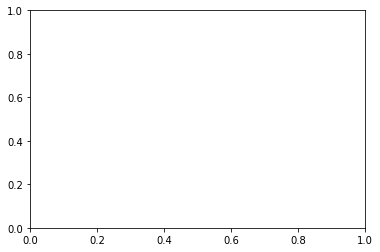

In [ ]:
print(waveform.shape)
waveform=waveform.numpy()
import matplotlib.pyplot as plt

time = np.arange(0, len(data_true)) * (1.0 / 16000)
#time = np.arange(0, len(samples)) *1


#a=[0,1,1,1,1,1,0,0,0,0,0]
#data=data_true.tolist()
redata=waveform.tolist()
time = np.arange(0, len(data)) * (1.0 / 16000)
print(data)
print(redata)
distance=[]
for i in range(len(data)):
  distance.append(redata[i]-data[i])

print(distance)
#redata=redata.tolist()
#nozeroindex = np.nonzero(distance)[0]
#print(nozeroindex)

plt.plot(time, redata, color='red', label='adversarial audio')
plt.plot(time, data, color='green', label='original audio')
plt.plot(time, distance,color='skyblue', label='Distance')
plt.legend() # 显示图例
#plt.title("语音信号时域波形")
plt.xlabel("TIME")
plt.ylabel("AMPTITUDE")
# plt.savefig("your dir\语音信号时域波形图", dpi=600)
plt.show()

In [ ]:
frame_length = 2048
frame_step = 512
waveform = tf.random.normal(dtype=tf.float32, shape=[1000])
stft = tf.signal.stft(waveform, frame_length, frame_step)
inverse_stft = tf.signal.inverse_stft(
    stft, frame_length, frame_step,
    window_fn=tf.signal.inverse_stft_window_fn(frame_step))

In [ ]:
print(waveform.shape)
print(inverse_stft.shape)

(1000,)
(1536,)
